In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.1.5


# Create Synthetic Rainbow with Transit

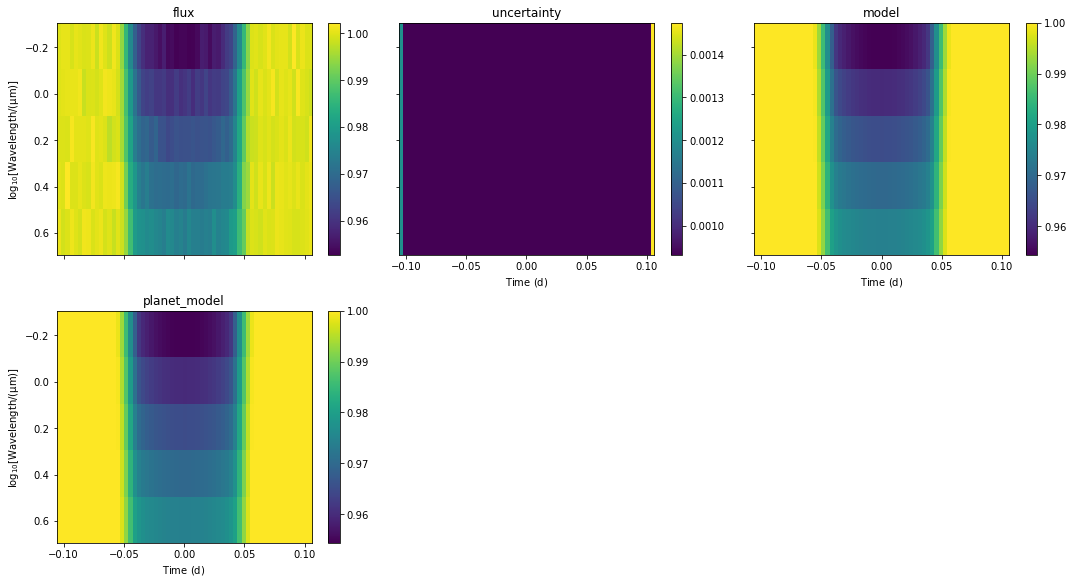

In [25]:
# create polynomial + transit rainbow:

r = SimulatedRainbow(signal_to_noise=100, dt=1 * u.minute, R=50)
r = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)

# add transit:
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave))

r.imshow_quantities();

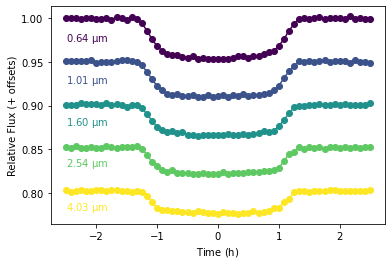

In [26]:
r.plot()

### Try Separate Fitting with Transit Model

In [27]:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

t.summarize_parameters()

t.attach_data(r)

t.choose_optimization_method("separate")
# print(t.optimization)

t.setup_lightcurves()

t.setup_likelihood()
print(t.pymc3_model[0])

stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>

stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 Fixed | 1 🧮>

epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>

baseline =
  <🧮 Fitted Uniform(lower=0.95, upper=1.05, name='baseline') 🧮>

impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>

limb_darkening =
  <🧮 Fitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') 🧮>



100%|█████████████████████████████████████████| 5/5 [00:00<00:00, 105916.77it/s]


             epoch_w0_interval__ ~ TransformedDistribution
    impact_parameter_w0_impact__ ~ TransformedDistribution
    stellar_radius_w0_interval__ ~ TransformedDistribution
      stellar_mass_w0_interval__ ~ TransformedDistribution
limb_darkening_w0_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w0 ~ Normal
          baseline_w0_interval__ ~ TransformedDistribution
                        epoch_w0 ~ Uniform
             impact_parameter_w0 ~ ImpactParameter
               stellar_radius_w0 ~ Uniform
                 stellar_mass_w0 ~ Uniform
               limb_darkening_w0 ~ QuadLimbDark
                     baseline_w0 ~ Uniform
               wavelength_0_data ~ Normal



🌈 Warning: invalid value encountered in log

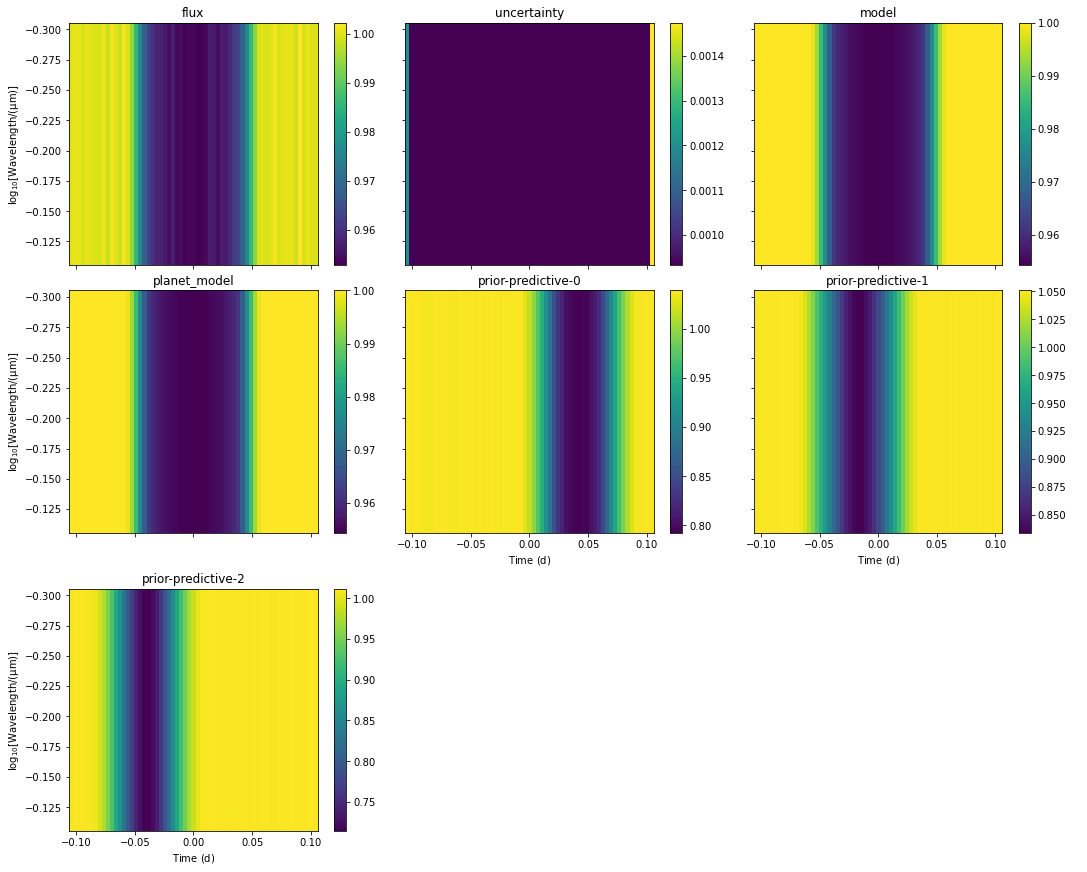

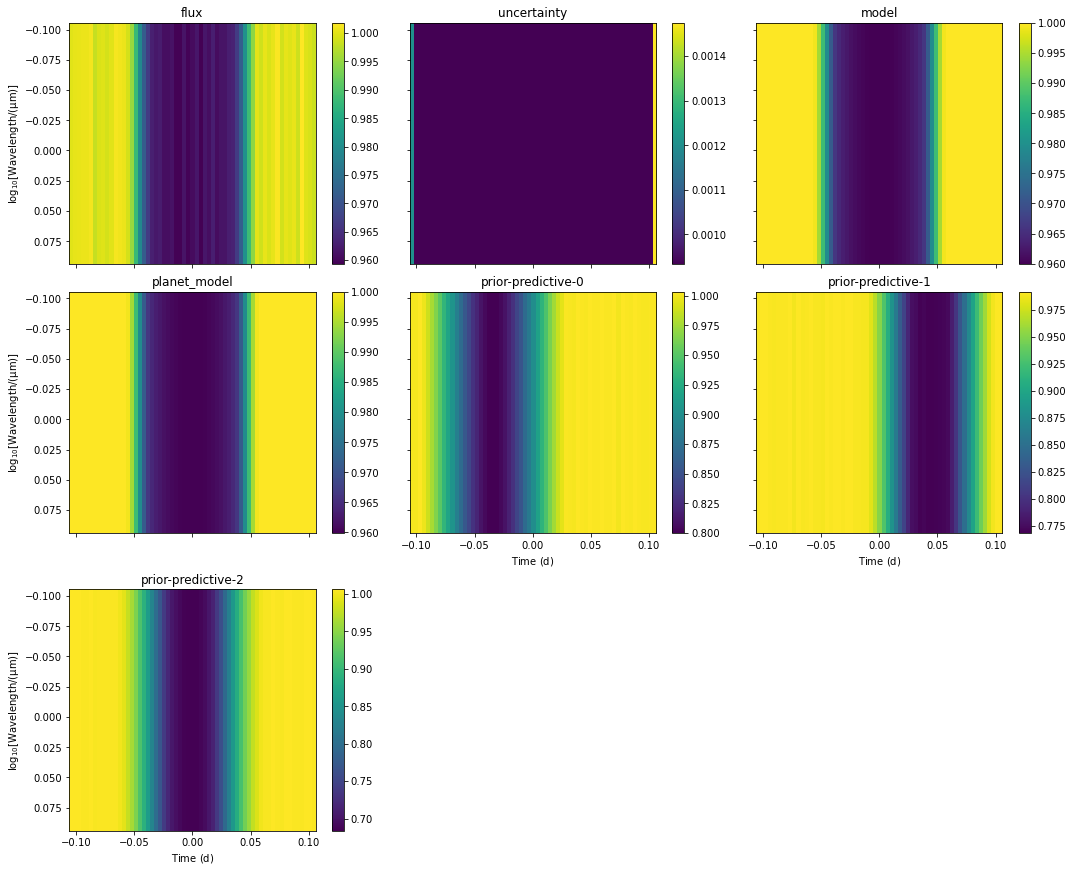

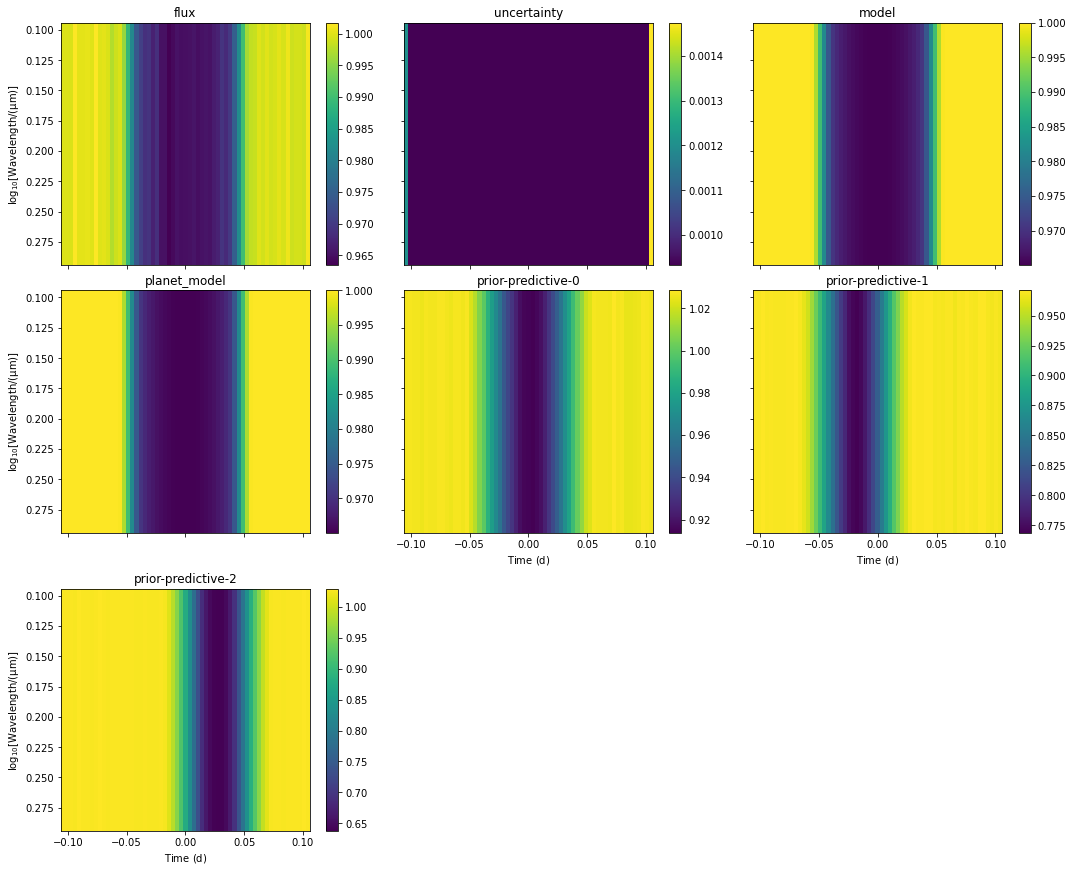

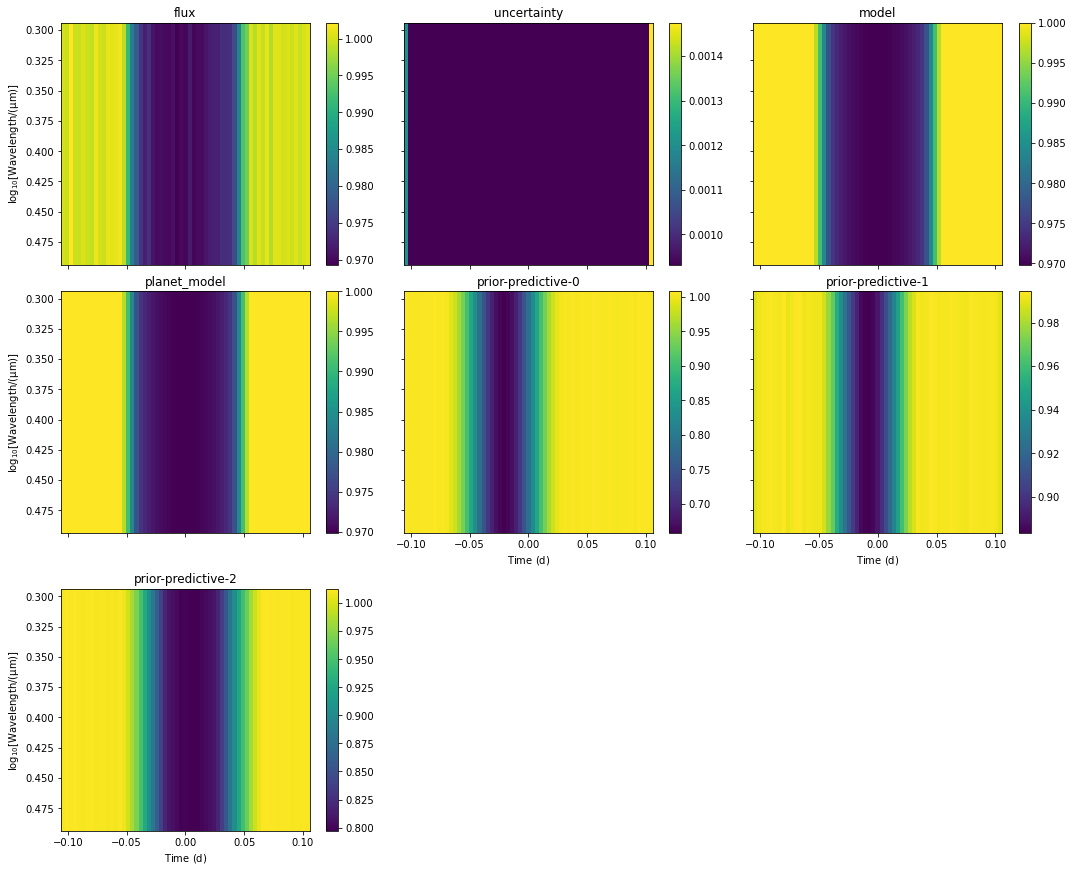

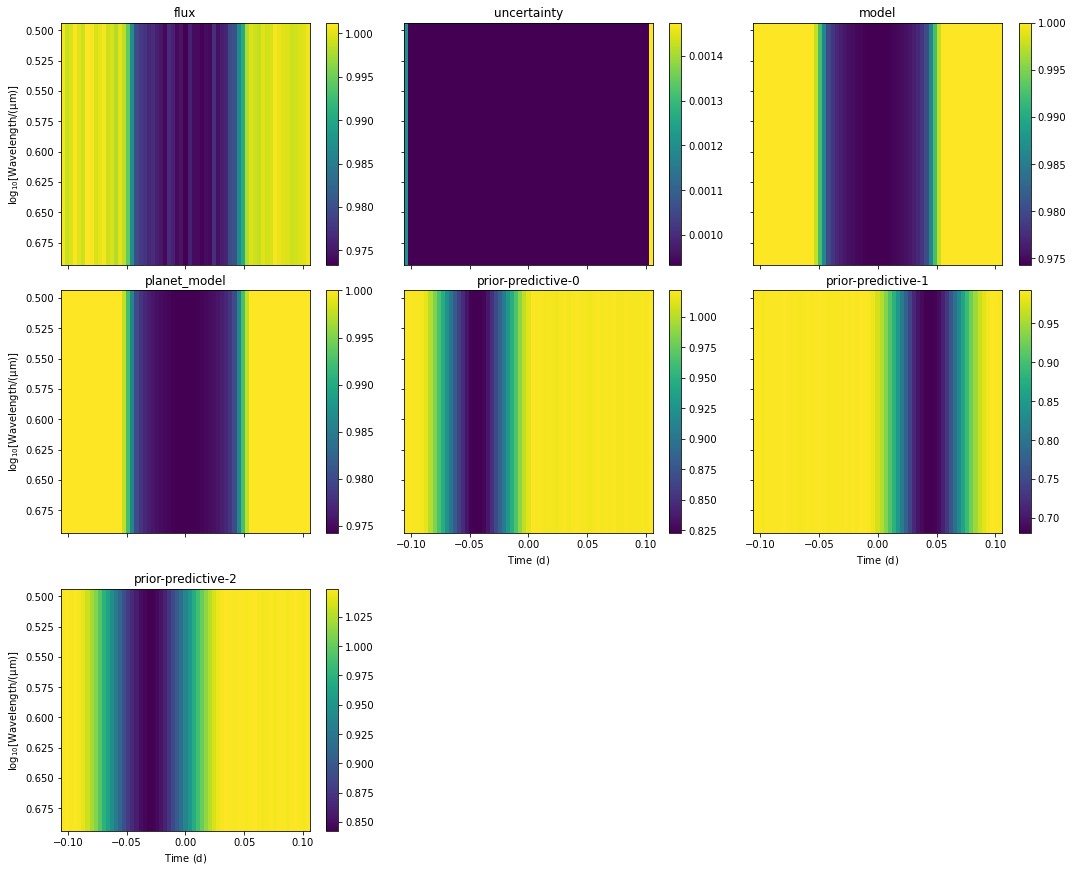

In [28]:
t.plot_priors()

In [29]:
t.sample()
t.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w0, radius_ratio_w0, limb_darkening_w0, stellar_mass_w0, stellar_radius_w0, impact_parameter_w0, epoch_w0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w1, radius_ratio_w1, limb_darkening_w1, stellar_mass_w1, stellar_radius_w1, impact_parameter_w1, epoch_w1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w2, radius_ratio_w2, limb_darkening_w2, stellar_mass_w2, stellar_radius_w2, impact_parameter_w2, epoch_w2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w3, radius_ratio_w3, limb_darkening_w3, stellar_mass_w3, stellar_radius_w3, impact_parameter_w3, epoch_w3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w4, radius_ratio_w4, limb_darkening_w4, stellar_mass_w4, stellar_radius_w4, impact_parameter_w4, epoch_w4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

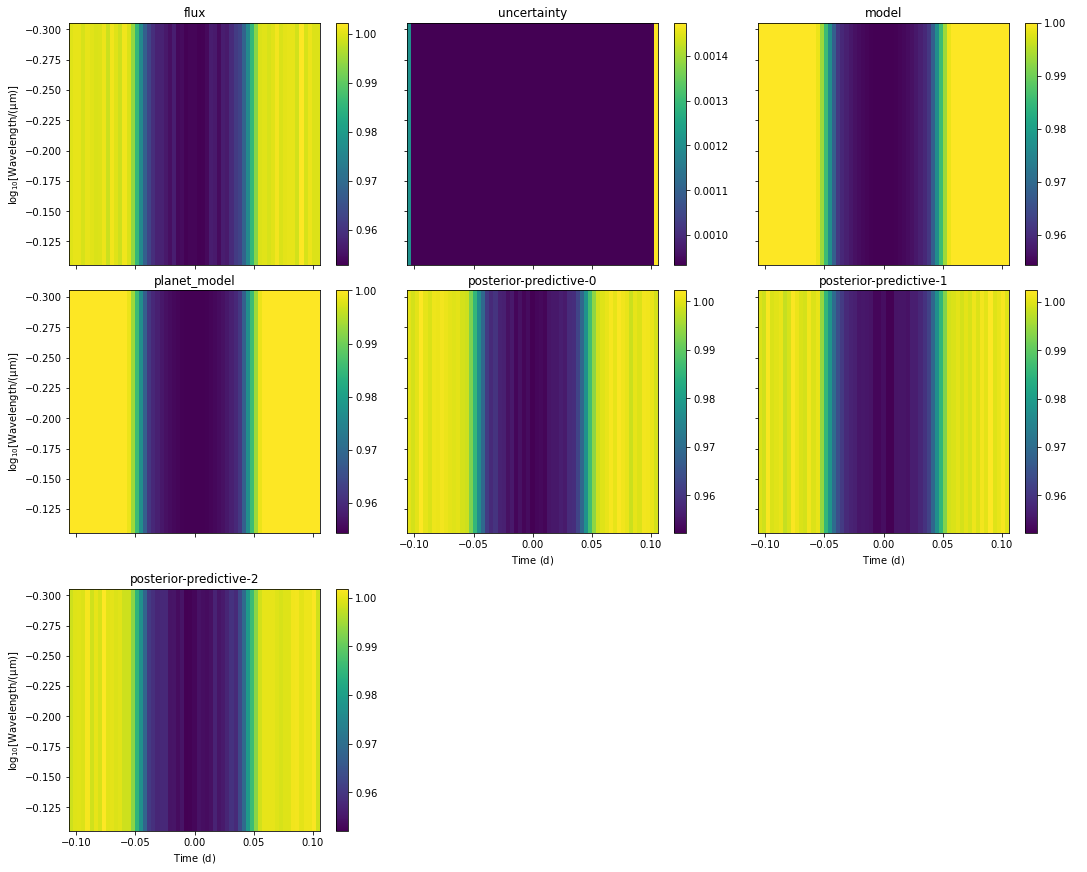

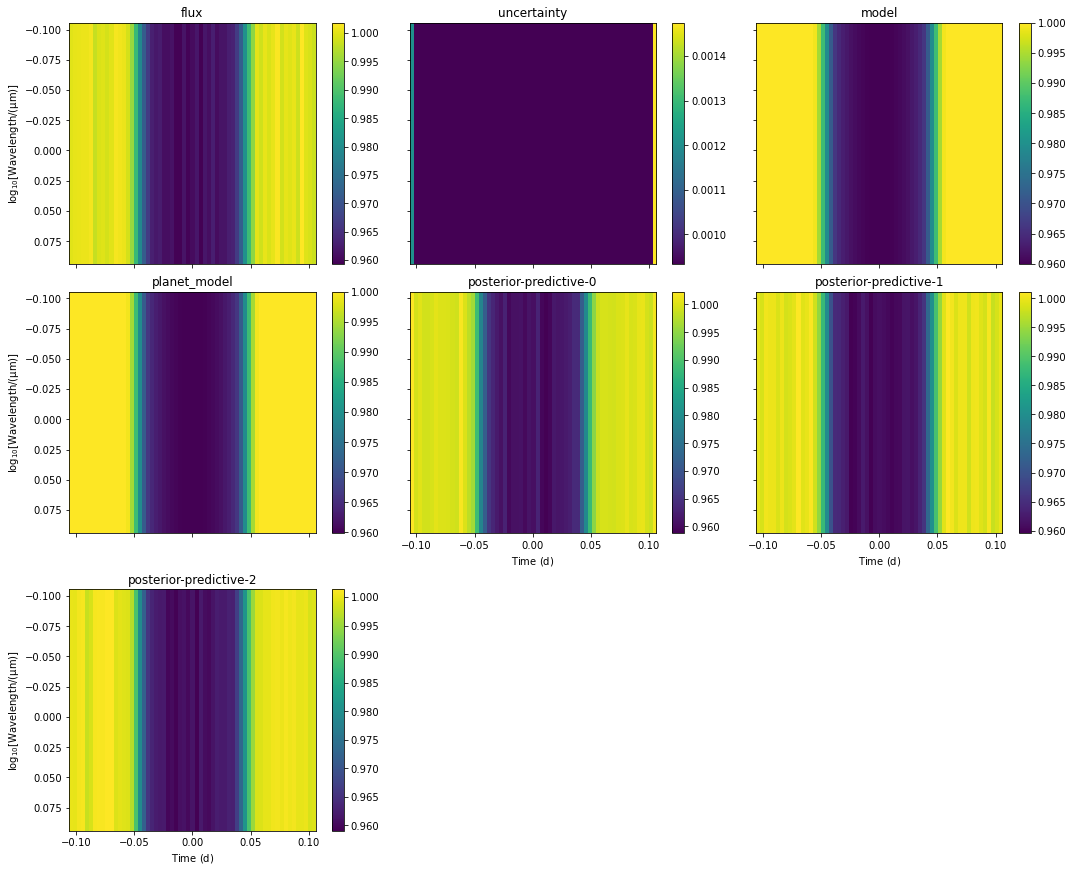

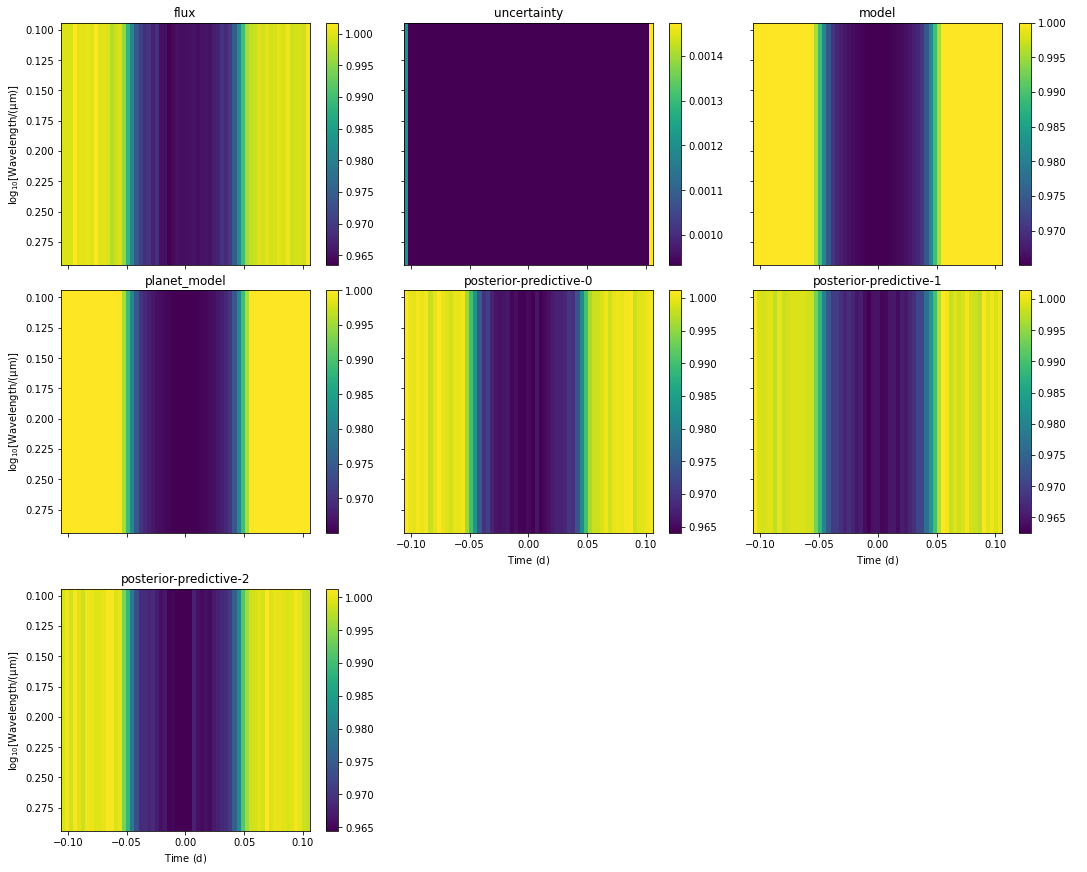

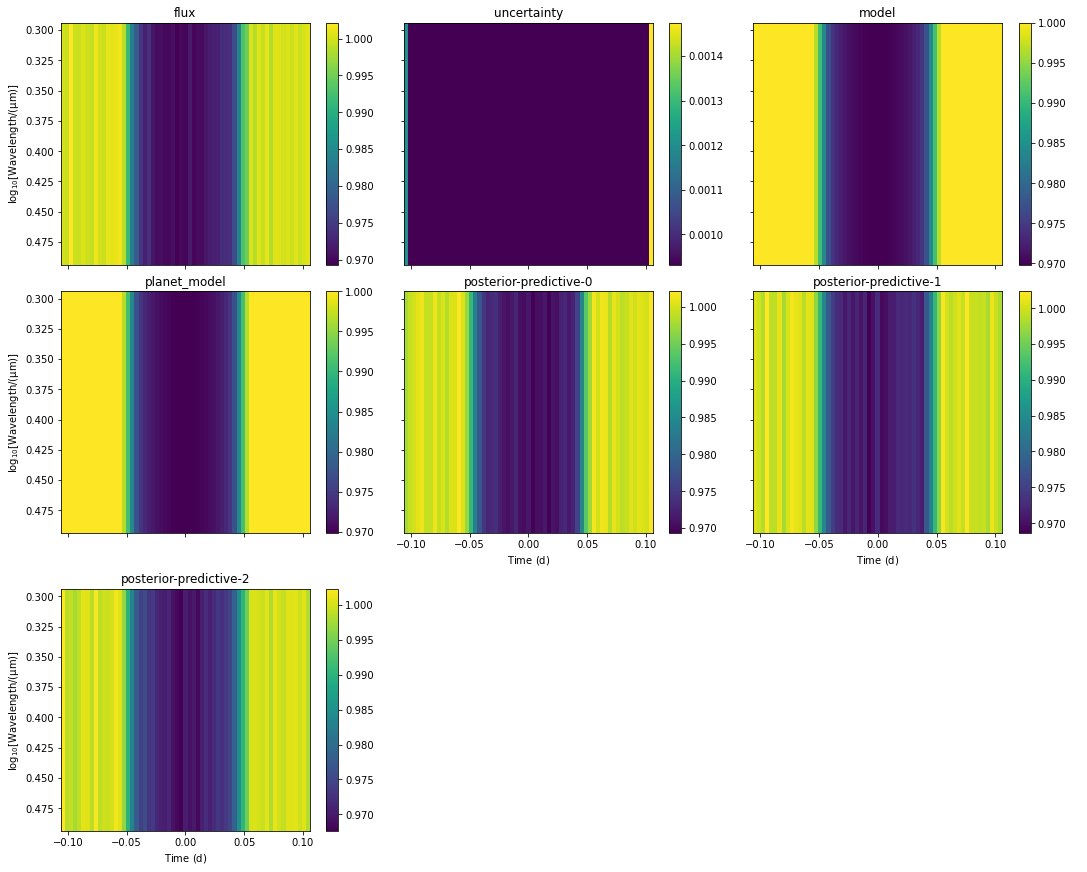

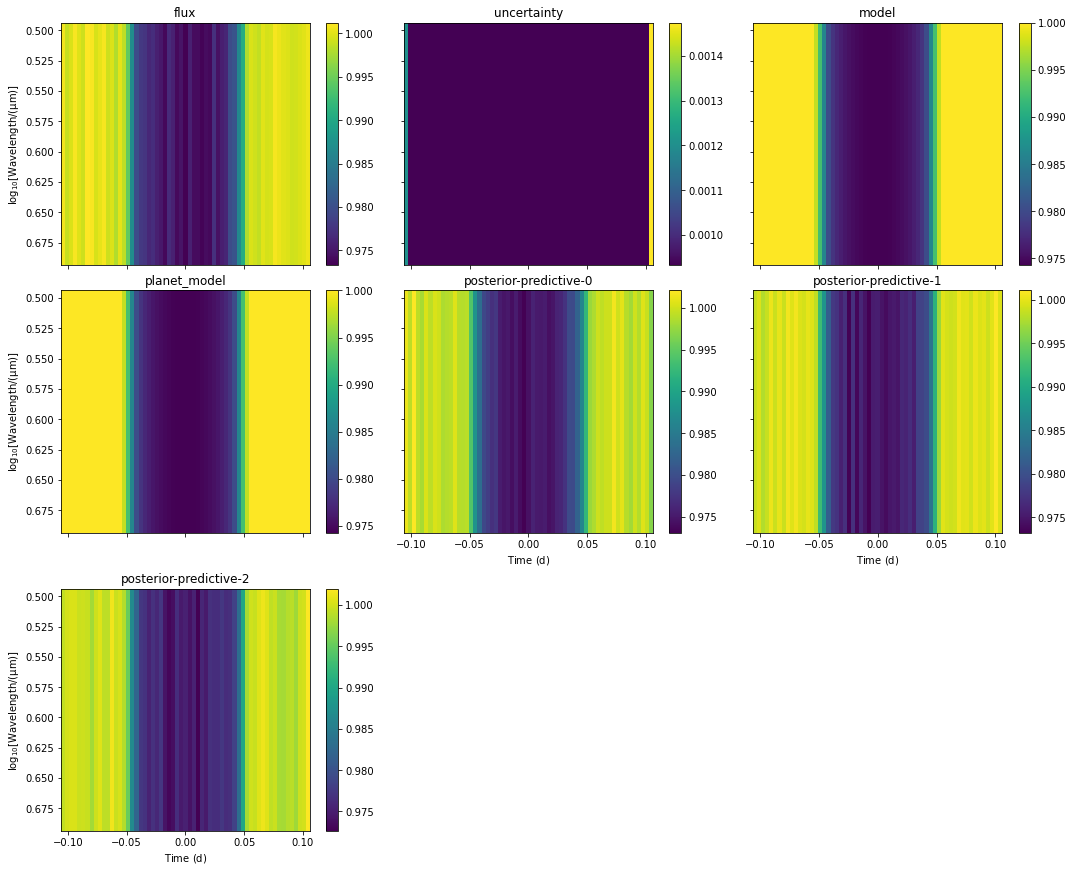

In [30]:
t.plot_posteriors()

In [14]:
def plot_2d_lightcurves(self):
    fig, ax = plt.subplots(figsize=(7,7))
    from matplotlib.pyplot import cm as cmap

    posterior_predictive_traces = self.sample_posterior(ndraws=50)

    for j, (mod, trace, summary, posterior_predictive_trace) in enumerate(zip(self.pymc3_model, self.trace, self.summary, posterior_predictive_traces)):
        if self.optimization == 'separate':
            data = self.get_data(j)
            spacing = 3 * np.nanstd(self.get_data(0).flux)
        else:
            data = self.get_data()
            spacing = 3 * np.nanstd(data.flux)

        color=cmap.viridis(np.linspace(0,1,data.nwave))

        posterior_means = summary['mean']

        # spacing = ax._most_recent_chromatic_plot_spacing
        for i, w in enumerate(data.wavelength):
            firstplot = True
            transit_params = self.extract_mean_posteriors(summary, i+j)
            transit = self.transit_model(transit_params)
            poly = []
#             transit_params = self.chromatic_models['transit'].extract_mean_posteriors(summary, i+j)#cm.chromatic_models['transit'].extract_mean_posteriors(summary, i+j)
#             poly_params = self.chromatic_models['polynomial'].extract_mean_posteriors(summary, i+j)#cm.chromatic_models['polynomial'].extract_mean_posteriors(summary, i+j)

#             poly = self.chromatic_models['polynomial'].polynomial_model(poly_params)
#             transit = self.chromatic_models['transit'].transit_model(transit_params)

            for k in range(50):
                if firstplot:
                    plt.plot(data.time, (-spacing*(i+j)) + posterior_predictive_trace[f'wavelength_{i+j}_data'][k],color='gray',alpha=0.3,label='Posterior Sample (n=50)')
                    firstplot=False
                else:
                    plt.plot(data.time, (-spacing*(i+j)) + posterior_predictive_trace[f'wavelength_{i+j}_data'][k],color='gray',alpha=0.3)

            plt.plot(data.time,(transit) + (-spacing*(i+j)),color='cyan')
            plt.plot(data.time, data.flux[i] + (-spacing*(i+j)),'.')
            plt.text(data.time[0].to_value(), data.flux[i][0] + (-spacing*(i+j)) + 0.01, s="%.2f"%w.to_value())

    plt.title(self.optimization)
    plt.ylabel("Relative Flux + offset")
    plt.xlabel("Time from Transit Epoch")
    plt.legend(loc='lower right',fontsize=8)
    plt.show()
    plt.close()
    

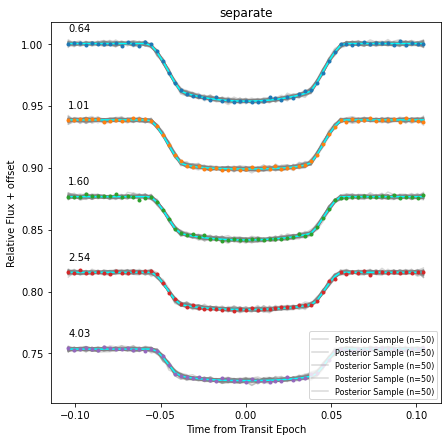

In [31]:
plot_2d_lightcurves(t)

## Try Simultaneous Transit Fit 

In [32]:
# need to reinitialise model due to known issue with separate wavelength-fitting
t2 = TransitModel()
t2.initialize_empty_model()

t2.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

t2.summarize_parameters()

t2.attach_data(r)

t2.setup_lightcurves()

t2.setup_likelihood()
print(t2.pymc3_model)

stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>

stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 Fixed | 1 🧮>

epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>

baseline =
  <🧮 Fitted Uniform(lower=0.95, upper=1.05, name='baseline') 🧮>

impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>

limb_darkening =
  <🧮 Fitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') 🧮>



100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 80971.12it/s]


             epoch_interval__ ~ TransformedDistribution
    impact_parameter_impact__ ~ TransformedDistribution
    stellar_radius_interval__ ~ TransformedDistribution
      stellar_mass_interval__ ~ TransformedDistribution
limb_darkening_quadlimbdark__ ~ TransformedDistribution
              radius_ratio_w0 ~ Normal
          baseline_interval__ ~ TransformedDistribution
              radius_ratio_w1 ~ Normal
              radius_ratio_w2 ~ Normal
              radius_ratio_w3 ~ Normal
              radius_ratio_w4 ~ Normal
                        epoch ~ Uniform
             impact_parameter ~ ImpactParameter
               stellar_radius ~ Uniform
                 stellar_mass ~ Uniform
               limb_darkening ~ QuadLimbDark
                     baseline ~ Uniform
            wavelength_0_data ~ Normal
            wavelength_1_data ~ Normal
            wavelength_2_data ~ Normal
            wavelength_3_data ~ Normal
            wavelength_4_data ~ Normal



🌈 Warning: invalid value encountered in log

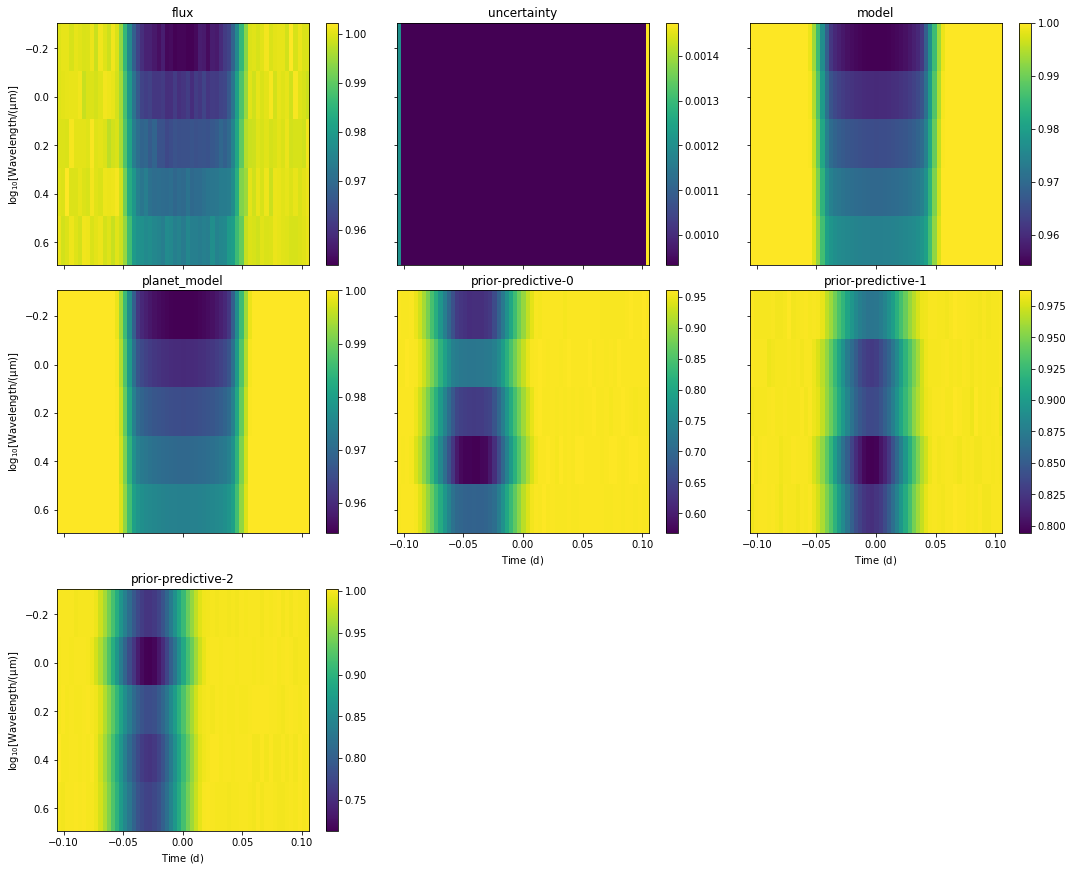

In [33]:
t2.plot_priors()

In [34]:
t2.sample()
t2.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [radius_ratio_w4, radius_ratio_w3, radius_ratio_w2, radius_ratio_w1, baseline, radius_ratio_w0, limb_darkening, stellar_mass, stellar_radius, impact_parameter, epoch]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 174 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

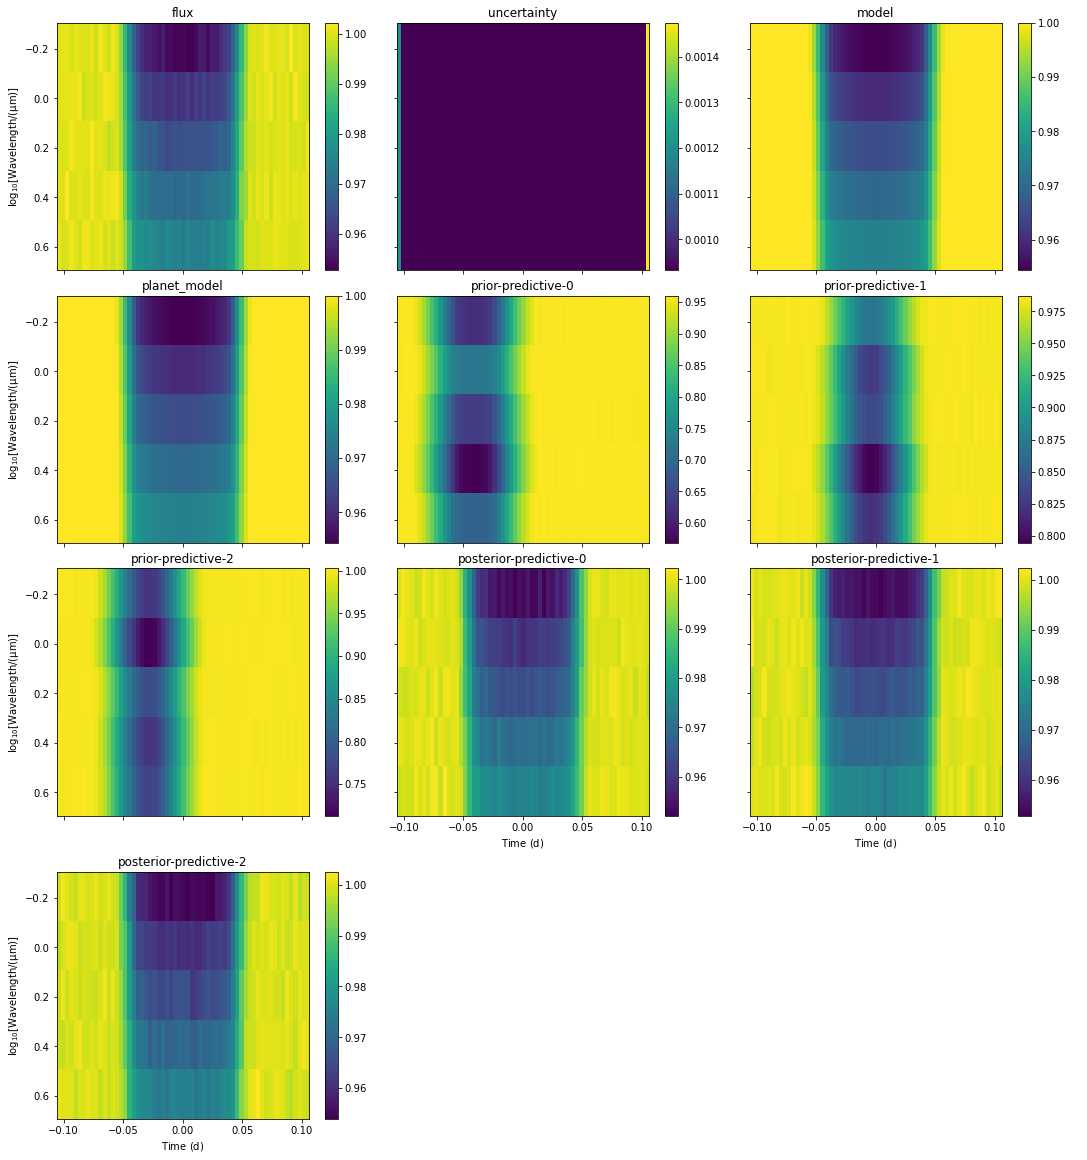

In [35]:
t2.plot_posteriors()

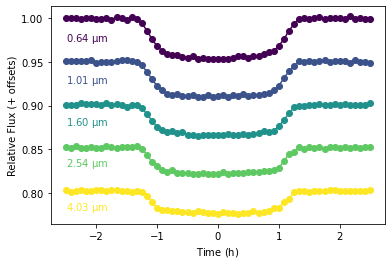

In [36]:
t2.plot_lightcurves()

## Compare Simultaneous and Separate Fits

In [137]:
def plot_transmisison_spectrum(self,ax=None, model=None,**kw):
    if ax is None:
        ax = plt.subplot()
    plt.sca(ax)
    ws, rr, drr = [],[],[]
    
    if self.optimization == "separate":
        summaries = self.summary
        datas = [self.get_data(i) for i in range(self.data.nwave)]
        wavelengths = [d.wavelength[0] for d in datas]
    else:
        summaries = [self.summary]
        datas = [self.get_data()]
        wavelengths = [self.get_data().wavelength]
        
    for i, (summary, data, wavelength) in enumerate(zip(summaries, datas, wavelengths)):
        posterior_means = summary['mean']
        posterior_sd = summary['sd']
        for w, wav in enumerate(data.wavelength):
            ws.append(wav.to_value())
            if "radius_ratio" in posterior_means.index:
                rr.append(posterior_means["radius_ratio"])
                drr.append(posterior_sd["radius_ratio"])
            elif f"radius_ratio_w{i+w}" in posterior_means.index:
                rr.append(posterior_means[f"radius_ratio_w{i+w}"])
                drr.append(posterior_sd[f"radius_ratio_w{i+w}"])
                
    if model is not None:
        plt.plot(model['wavelength'],model['rr'],'k',alpha=0.3,label="Model Spectrum")
                
    plt.plot(ws,rr,'.',markersize=10,**kw)
    plt.errorbar(ws,rr,drr,alpha=0.5,capsize=5,linestyle='None',**kw)
    plt.title("Transmission Spectrum")
    plt.ylabel("Rp/R*")
    plt.xlabel(f"Wavelength")
    plt.legend()


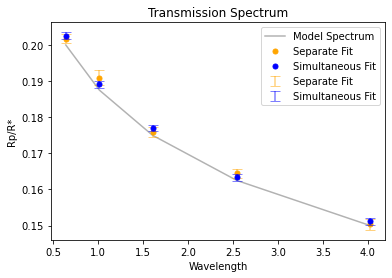

In [138]:
ax = plt.subplot()
model = {'wavelength':r.wavelength,'rr':np.linspace(0.2, 0.15, r.nwave)}
plot_transmisison_spectrum(t, ax, model=model, color="orange",label="Separate Fit")
plot_transmisison_spectrum(t2, ax, color='blue', label="Simultaneous Fit")

In [112]:
t2.summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
radius_ratio_w0,0.202530,0.000992,0.200764,0.204423,0.000048,0.000034,405.856881,278.862007,1.010653
radius_ratio_w1,0.189110,0.000937,0.187407,0.190855,0.000037,0.000026,650.833181,1545.399856,1.004980
radius_ratio_w2,0.176982,0.000881,0.175439,0.178674,0.000032,0.000023,717.548018,1102.186280,1.005000
radius_ratio_w3,0.163320,0.000886,0.161690,0.164953,0.000036,0.000025,611.096474,727.840288,1.006365
radius_ratio_w4,0.151164,0.000905,0.149406,0.152855,0.000033,0.000024,737.476279,796.879101,1.006868
epoch,-0.000012,0.000072,-0.000151,0.000119,0.000001,0.000001,2697.991850,2022.749561,1.002574
impact_parameter,0.079005,0.053539,0.000650,0.171449,0.002388,0.002024,550.227055,334.261342,1.005159
stellar_radius,1.176745,0.014045,1.154334,1.199993,0.000684,0.000484,403.313336,236.652849,1.019743
stellar_mass,0.863744,0.031190,0.812342,0.920182,0.001354,0.000958,495.095614,484.488063,1.019954
limb_darkening[0],0.323002,0.054896,0.220188,0.423891,0.002681,0.002202,328.560852,138.627140,1.018162


## Add polynomial

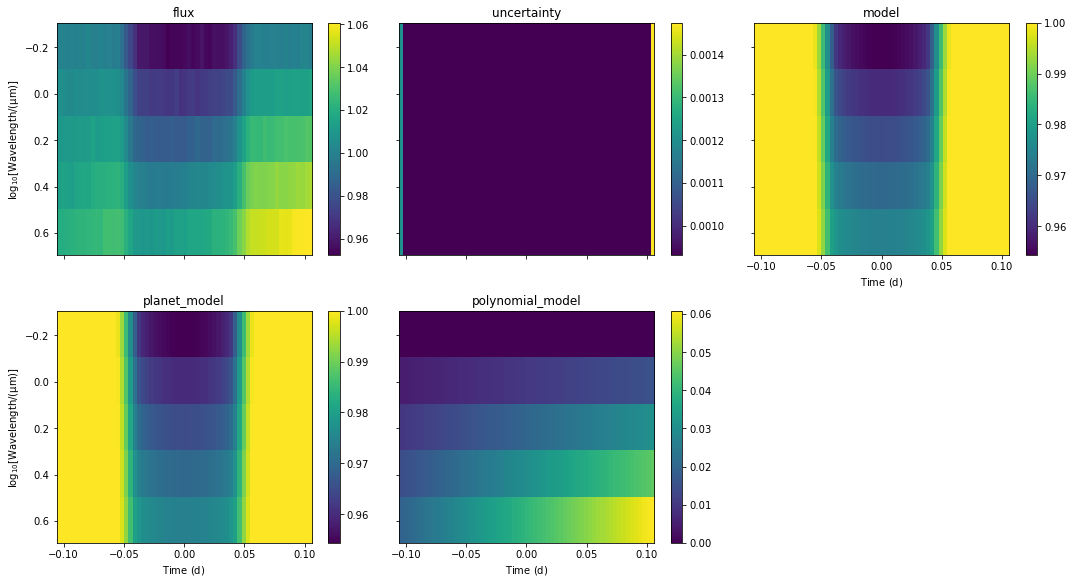

In [10]:
# create wavelength-dep linear model:
poly=[]
for i in range(r.nwave):
#     (0.5*i*(r1.time.to_value())**2) +
    poly.append((0.05*i*r.time.to_value()) + (0.01*i))
r.flux = r.flux + poly
    
r.fluxlike['polynomial_model'] = np.array(poly)
r.imshow_quantities();

### Setup Polynomial model

In [11]:
# set up polynomial model:
b = PolynomialModel()
b.initialize_empty_model()
b.setup_parameters(p=WavelikeFitted(Uniform,testval=[0,0.1],upper=[0.1,0.2],lower=[-0.1,-0.2],shape=2))

### Combined Transit + Polynomial Model:

In [12]:
t3 = TransitModel()
t3.initialize_empty_model()

t3.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

In [67]:
## combine the models!
cm = CombinedModel()
cm.initialize_empty_model()
cm.attach_models({'transit':t3,'polynomial':b})
cm.attach_data(r)
cm.setup_lightcurves()
cm.setup_likelihood()
print(cm.chromatic_models)
print(cm.pymc3_model)

100%|█████████████████████████████████████████| 5/5 [00:00<00:00, 108660.73it/s]


{'transit': <experimental chromatic transit model 🌈>, 'polynomial': <experimental chromatic polynomial model 🌈>}
             epoch_interval__ ~ TransformedDistribution
    impact_parameter_impact__ ~ TransformedDistribution
    stellar_radius_interval__ ~ TransformedDistribution
      stellar_mass_interval__ ~ TransformedDistribution
limb_darkening_quadlimbdark__ ~ TransformedDistribution
              radius_ratio_w0 ~ Normal
          baseline_interval__ ~ TransformedDistribution
              radius_ratio_w1 ~ Normal
              radius_ratio_w2 ~ Normal
              radius_ratio_w3 ~ Normal
              radius_ratio_w4 ~ Normal
              p_w0_interval__ ~ TransformedDistribution
              p_w1_interval__ ~ TransformedDistribution
              p_w2_interval__ ~ TransformedDistribution
              p_w3_interval__ ~ TransformedDistribution
              p_w4_interval__ ~ TransformedDistribution
                        epoch ~ Uniform
             impact_parameter ~ Impa


🌈 Warning: invalid value encountered in log

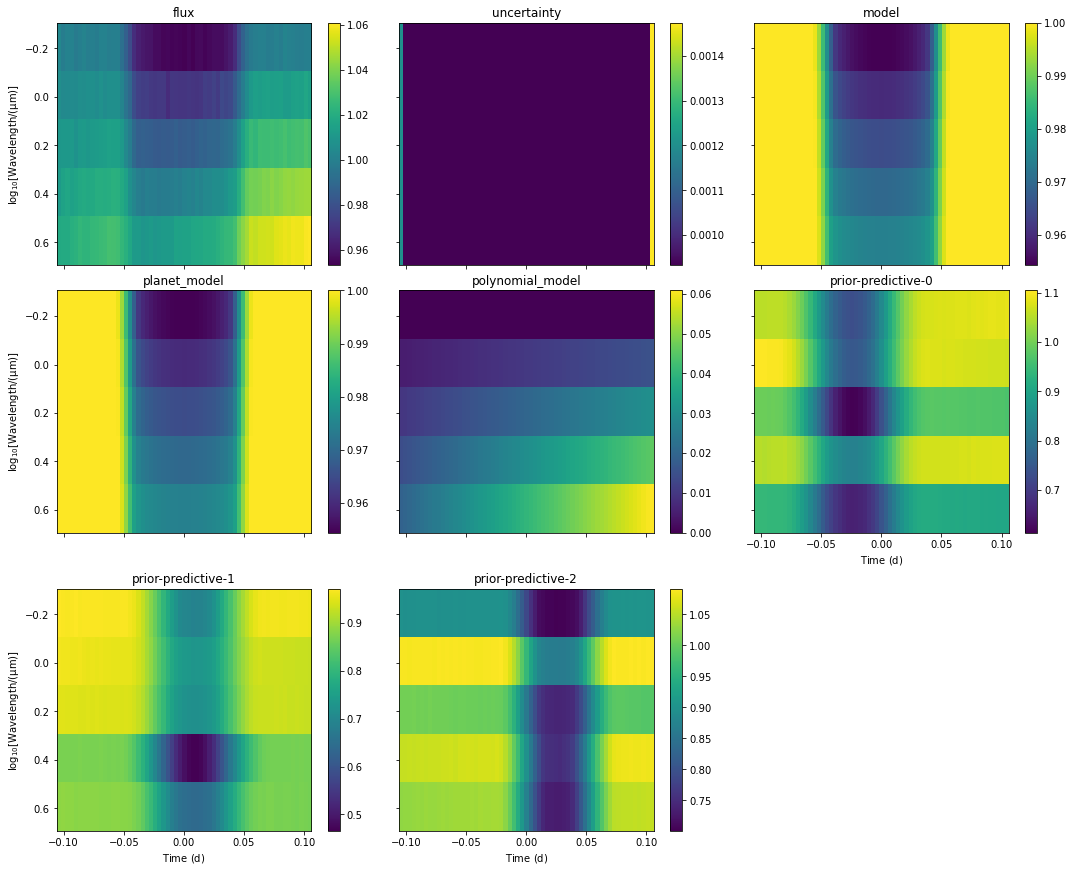

In [68]:
cm.plot_priors()

In [ ]:
cm.sample(tune=3000, draws=3000, cores=12, chains=4)
cm.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [p_w4, p_w3, p_w2, p_w1, p_w0, radius_ratio_w4, radius_ratio_w3, radius_ratio_w2, radius_ratio_w1, baseline, radius_ratio_w0, limb_darkening, stellar_mass, stellar_radius, impact_parameter, epoch]



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

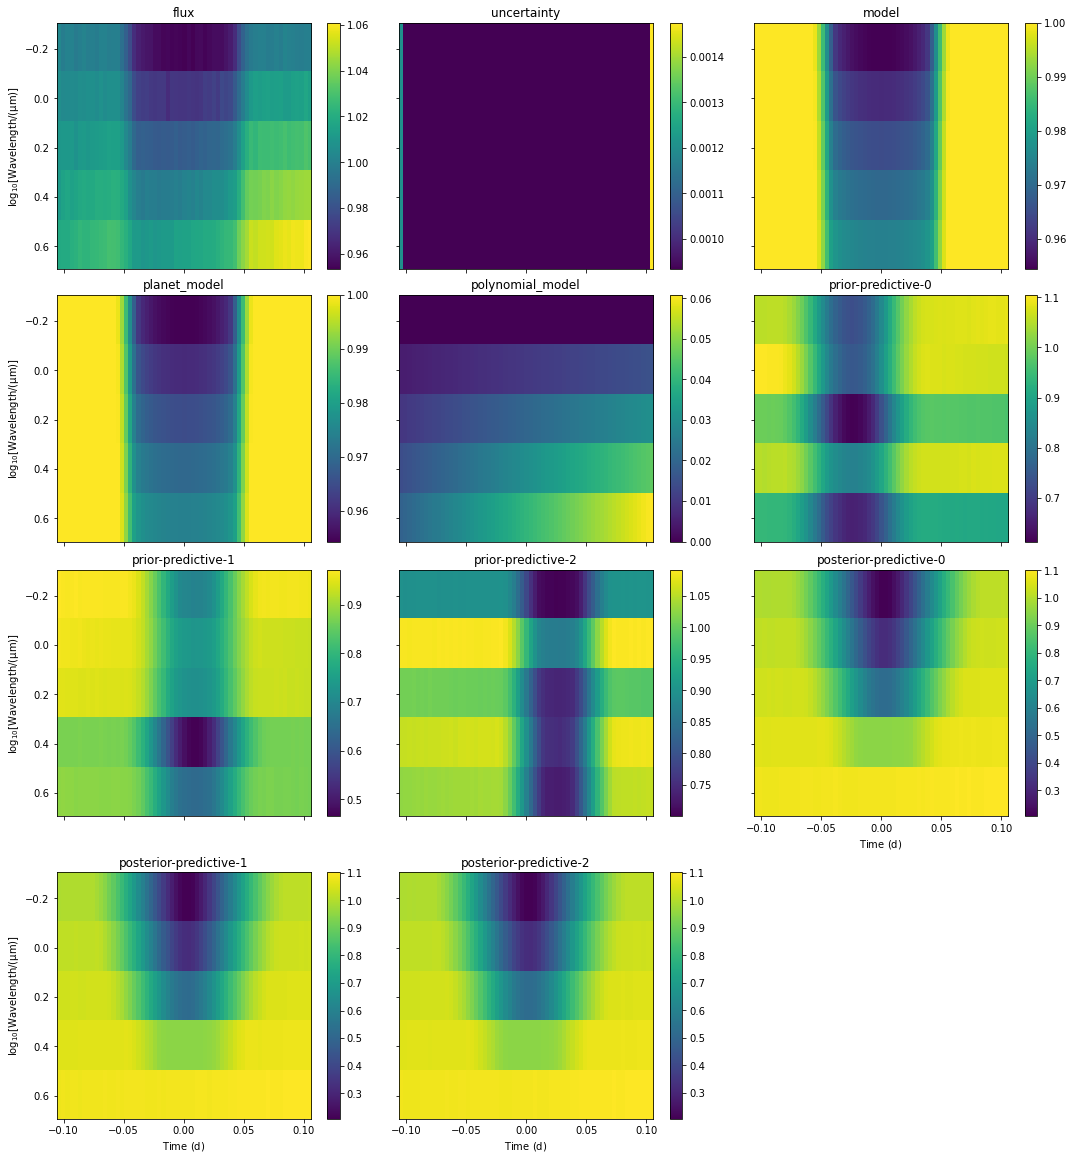

In [70]:
cm.plot_posteriors()